## Setup

In [156]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import datetime

import functools
import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn


import glucose_ts

# plot layouts
sns.set_style("whitegrid")
sns.set_context(
    "talk",
    rc={
        "axes.titlesize": 36,
        "axes.labelsize": 36,
        "lines.linewidth": 5,
        "lines.markersize": 10,
        "xtick.labelsize": 30,
        "ytick.labelsize": 30,
        'legend.fontsize': 24,
        'figsize': (20, 20),
    }
)
sns.color_palette("dark")

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')

FIG_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'presentations', 'images')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

## Load and Normalize the data


In [2]:
max_time = (19, 30)

base_path = os.path.join(DATA_DIR, 'standards_warm')

def get_calibration_curves(base_path, max_time):
    callibration_paths = [
        os.path.join(base_path, one)
        for one in tuple(os.walk(base_path))[0][2]
        if tuple([
            int(number.split('.')[0]) 
            for number in one.split('__')[1].split('_')[:2]
        ]) < max_time
    ]


    return sorted(
        [
            glucose_ts.data.read_glucose_ts(path)
            for path in callibration_paths
        ],
        key=lambda one: one.real_concentration
    )

curves = {
    'No. 1 at room temperature': get_calibration_curves(os.path.join(DATA_DIR, 'calibration'), (25, 0)),
    'No. 2 at 37 degrees': get_calibration_curves(os.path.join(DATA_DIR, 'standards_warm'), (19, 30)),
    'No. 3 at 37 degrees': get_calibration_curves(os.path.join(DATA_DIR, 'warm_standards_hamilton'), (20, 15)),
}


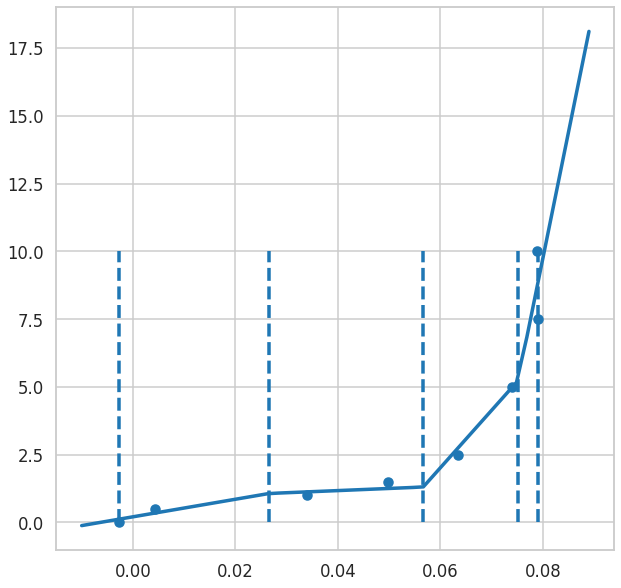

In [149]:
import random




one_set = curves['No. 1 at room temperature']
cut_off = 200
random.shuffle(one_set)
one_set = sorted(one_set[:-1], key=lambda one: one.real_concentration)


voltage_differences = np.array([
    one_series.voltages[0] - one_series.voltages[cut_off]
    for one_series in one_set
])
concentrations = np.array([
    one_series.real_concentration
    for one_series in one_set
])

model = make_pipeline(
    SplineTransformer(
        n_knots=5,
        degree=1,
        extrapolation='linear',
        knots='quantile',
    ),
    linear_model.LinearRegression(positive=False),
).fit(
    voltage_differences[:, np.newaxis],
    concentrations,
)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

differences = np.linspace(-0.01, max(voltage_differences) + 0.01)

ax.scatter(voltage_differences, concentrations)
ax.plot(differences, model.predict(differences[:, np.newaxis]))

knots = model.steps[0][1].bsplines_[0].t
ax.vlines(knots[1:-1], ymin=0, ymax=10, linestyles='dashed')



In [58]:
model.steps[0]

('splinetransformer', SplineTransformer(degree=1, extrapolation='linear'))

In [124]:
SplineTransformer(
    n_knots=5,
    degree=1,
    knots='quantile'
).fit_transform(
    voltage_differences[:, np.newaxis],
), voltage_differences

(array([[0.35135135, 0.64864865, 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.11711712, 0.88288288, 0.        , 0.        , 0.        ],
        [0.        , 0.88888889, 0.11111111, 0.        , 0.        ],
        [0.        , 0.27350427, 0.72649573, 0.        , 0.        ],
        [0.        , 0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.84609652, 0.15390348, 0.        ],
        [0.        , 0.        , 0.27221912, 0.72778088, 0.        ],
        [0.        , 0.        , 0.        , 0.81362419, 0.18637581],
        [0.        , 0.        , 0.        , 0.3666284 , 0.6333716 ],
        [0.        , 0.        , 0.        , 0.        , 1.        ]]),
 array([0.00246875, 0.00134375, 0.002875  , 0.00328125, 0.00440625,
        0.00490625, 0.0178125 , 0.0659375 , 0.11159375, 0.16634375,
        0.21125   ]))

Mean Absolute Error of sensor No. 1 at room temperature amounts to 0.8178
Mean Absolute Error of sensor No. 2 at 37 degrees amounts to 0.2244
Mean Absolute Error of sensor No. 3 at 37 degrees amounts to 0.3269


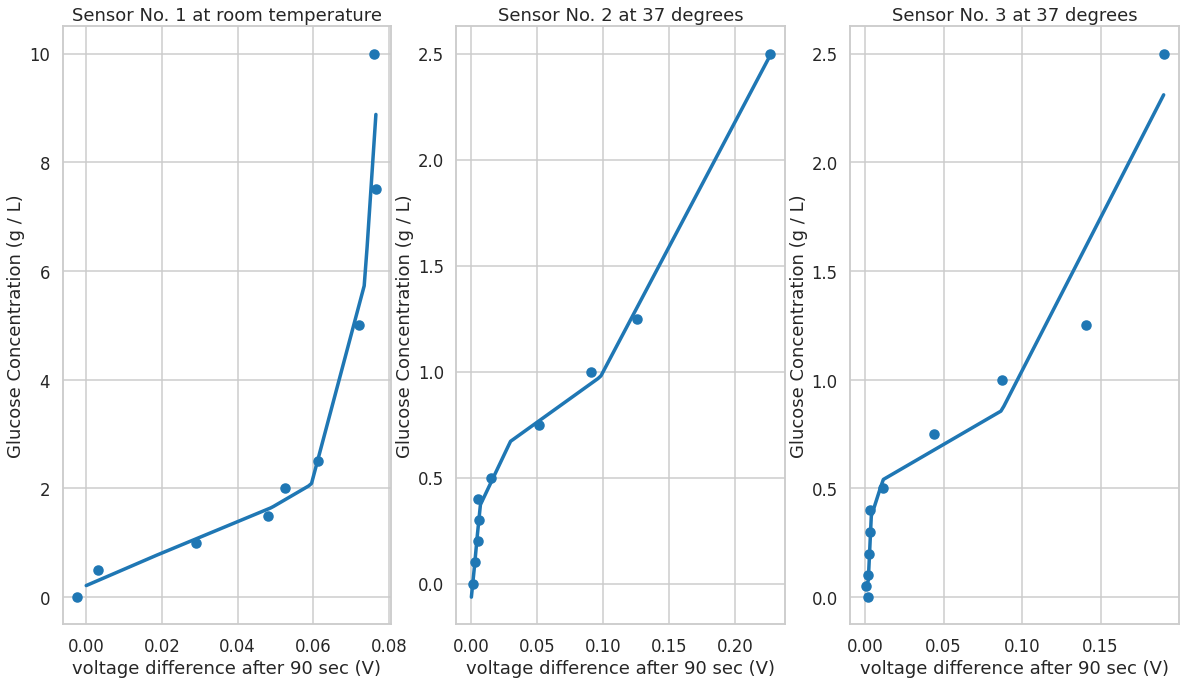

In [142]:
import math
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn import model_selection


def mae_by_cut_off(cut_off_seconds, curves, glucose_split):
    cut_off = int(cut_off_seconds/ (8.80 * 60 / 1000) )    
    voltage_differences = np.array([
        one_series.voltages[0] - one_series.voltages[cut_off]
        for one_series in curves
    ])
    voltage_differences_lower = np.array([
        one_series.voltages[0] - one_series.voltages[cut_off]
        for one_series in curves
        if one_series.real_concentration < glucose_split
    ])


    concentrations = np.array([
        one_series.real_concentration
        for one_series in curves
    ])
    
    concentrations_lower = np.array([
        one_series.real_concentration
        for one_series in curves
        if one_series.real_concentration < glucose_split
    ])
    model = linear_model.LinearRegression(fit_intercept=False).fit(
        voltage_differences[:, np.newaxis],
        concentrations,
    )
    
#     model = glucose_ts.models.ExpGlucose().fit(
#         voltage_differences[:, np.newaxis],
#         concentrations
#     )
    
#     model = make_pipeline(
#         PolynomialFeatures(3, include_bias=False),
#         linear_model.LinearRegression(fit_intercept=False)
#     ).fit(
#         voltage_differences[:, np.newaxis],
#         concentrations
#     )

    # spline model
    model_definition = make_pipeline(
        SplineTransformer(
        n_knots=6,
        degree=1,
        extrapolation='linear',
        knots='quantile',
        ),
        linear_model.LinearRegression()
    )
    model = model_definition.fit(
        voltage_differences[:, np.newaxis],
        concentrations,
    )
    
    cv_results = model_selection.cross_validate(
        model_definition,
        voltage_differences[:, np.newaxis],
        concentrations,
        cv=6,
        scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error')
    )
    mae = -1. * np.mean(cv_results['test_neg_mean_absolute_error'])
    rmse = -1. *np.mean(cv_results['test_neg_root_mean_squared_error'])
    
    mae_lower = sklearn.metrics.mean_absolute_error(
        concentrations_lower,
        model.predict(voltage_differences_lower[:, np.newaxis])    
    )

#     mae_everything = sklearn.metrics.mean_absolute_error(
#         concentrations,
#         model.predict(voltage_differences[:, np.newaxis])
#     )    
    return mae, rmse, model, voltage_differences, concentrations

cut_off_sec = 90
glucose_split = 0.8
mae_results_one_split = {
    key: mae_by_cut_off(
        cut_off_sec,
        one_set,
        glucose_split=glucose_split,
    )
    for key, one_set in curves.items()
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 11))

for (
    ax,
    (
        key,
        (
            mae,
            rmse,
            model,
            voltage_differences,
            concentrations
        )
    )
) in zip(axes, mae_results_one_split.items()):
    ax.scatter(
        voltage_differences,
        concentrations,
    )
    
    print('Mean Absolute Error of sensor %s amounts to %6.4f' % (key, mae))

    ax.plot(
        np.linspace(0., np.max(voltage_differences), 100),
        model.predict(np.linspace(0., np.max(voltage_differences), 100)[:, np.newaxis])
    )

    ax.set_title('Sensor %s' % (key))
    ax.set_xlabel('voltage difference after %s sec (V)' % cut_off_sec)
    ax.set_ylabel('Glucose Concentration (g / L)')
    

fig.savefig(
    os.path.join(
        FIG_DIR,
        'piecewise_linear.png'
    ),
    transparent=True,    
)



Mean Absolute Error of sensor No. 3 at 37 degrees amounts to 0.3106


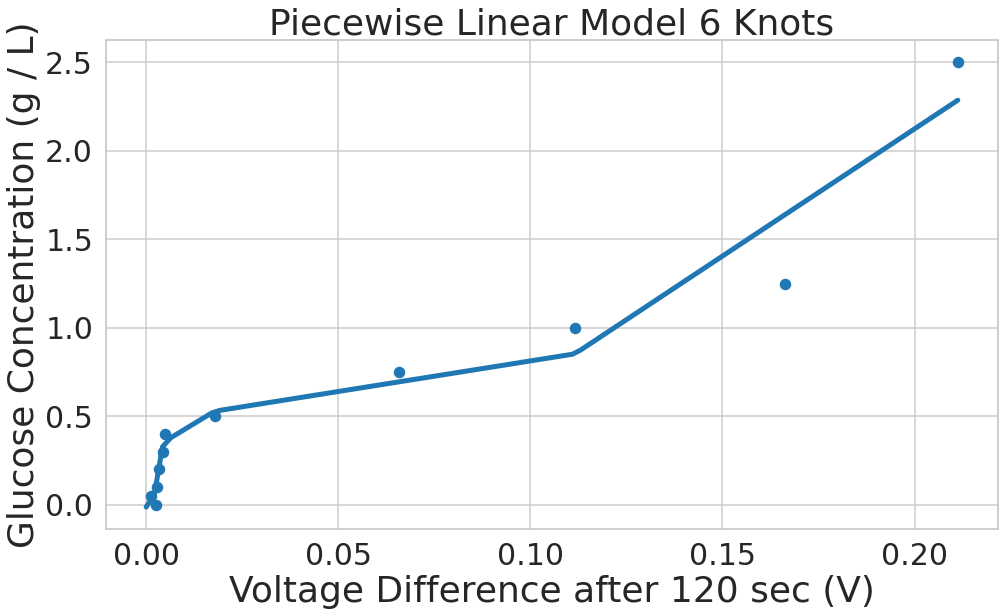

In [159]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

(
    mae,
    rmse,
    model,
    voltage_differences,
    concentrations
) = mae_results_one_split['No. 3 at 37 degrees']
    
ax.scatter(
    voltage_differences,
    concentrations,
)

print('Mean Absolute Error of sensor %s amounts to %6.4f' % (key, mae))

ax.plot(
    np.linspace(0., np.max(voltage_differences), 100),
    model.predict(np.linspace(0., np.max(voltage_differences), 100)[:, np.newaxis])
)

ax.set_title('Piecewise Linear Model 6 Knots')
ax.set_xlabel('Voltage Difference after %s sec (V)' % cut_off_sec)
ax.set_ylabel('Glucose Concentration (g / L)')
    

fig.savefig(
    os.path.join(
        FIG_DIR,
        'piecewise_linear_sensor_3.png'
    ),
    transparent=True,    
)


Mean Absolute Error of sensor No. 1 at room temperature amounts to 1.9985
Mean Absolute Error of sensor No. 2 at 37 degrees amounts to 0.1979
Mean Absolute Error of sensor No. 3 at 37 degrees amounts to 0.3106


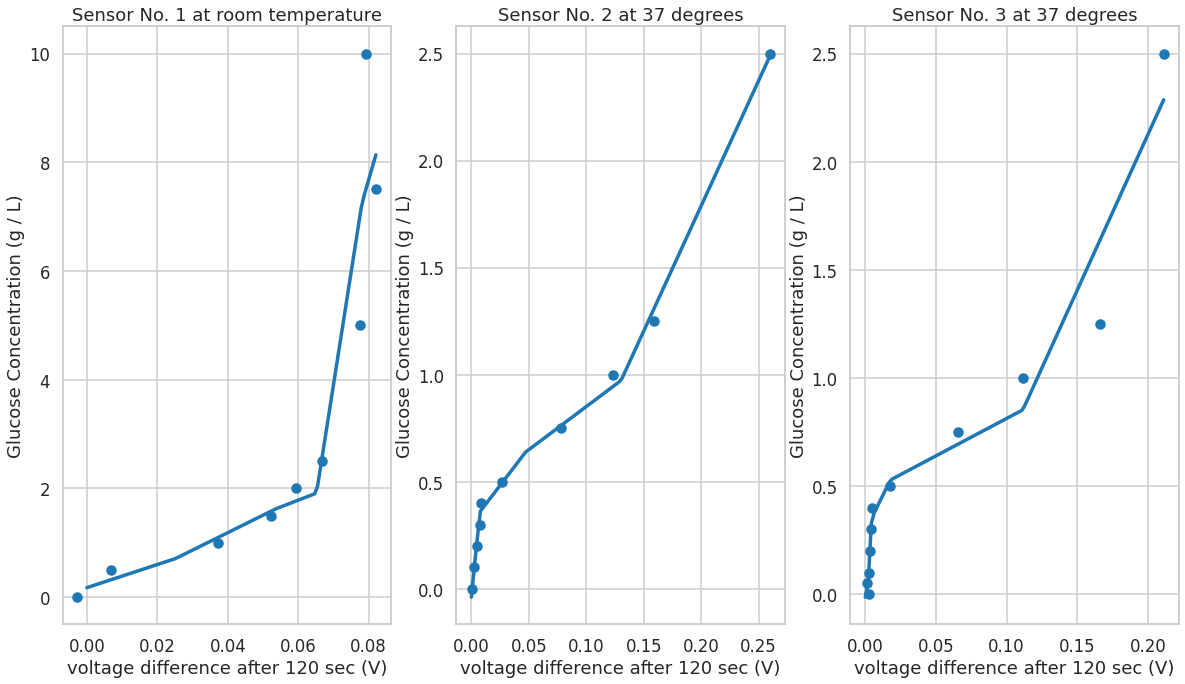

In [143]:
cut_off_sec = 120
glucose_split = 0.8
mae_results_one_split = {
    key: mae_by_cut_off(
        cut_off_sec,
        one_set,
        glucose_split=glucose_split,
    )
    for key, one_set in curves.items()
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 11))

for (
    ax,
    (
        key,
        (
            mae,
            rmse,
            model,
            voltage_differences,
            concentrations
        )
    )
) in zip(axes, mae_results_one_split.items()):
    ax.scatter(
        voltage_differences,
        concentrations,
    )
    
    print('Mean Absolute Error of sensor %s amounts to %6.4f' % (key, mae))

    ax.plot(
        np.linspace(0., np.max(voltage_differences), 100),
        model.predict(np.linspace(0., np.max(voltage_differences), 100)[:, np.newaxis])
    )

    ax.set_title('Sensor %s' % (key))
    ax.set_xlabel('voltage difference after %s sec (V)' % cut_off_sec)
    ax.set_ylabel('Glucose Concentration (g / L)')
    

fig.savefig(
    os.path.join(
        FIG_DIR,
        'final_voltage_vs_.png'
    ),
    transparent=True,    
)



# Baseline Model for Callibration Curves

## Glucose Batch Callibration Curves

In [144]:
cut_offs = np.linspace(10, int(8.5 * 60), 100)

glucose_split = 0.8

errors_by_cut_off = {
    key: [
        mae_by_cut_off(cut_off_sec, one_curve_set, glucose_split)[:3]
        for cut_off_sec in cut_offs
    ]
    for key, one_curve_set in curves.items()
}


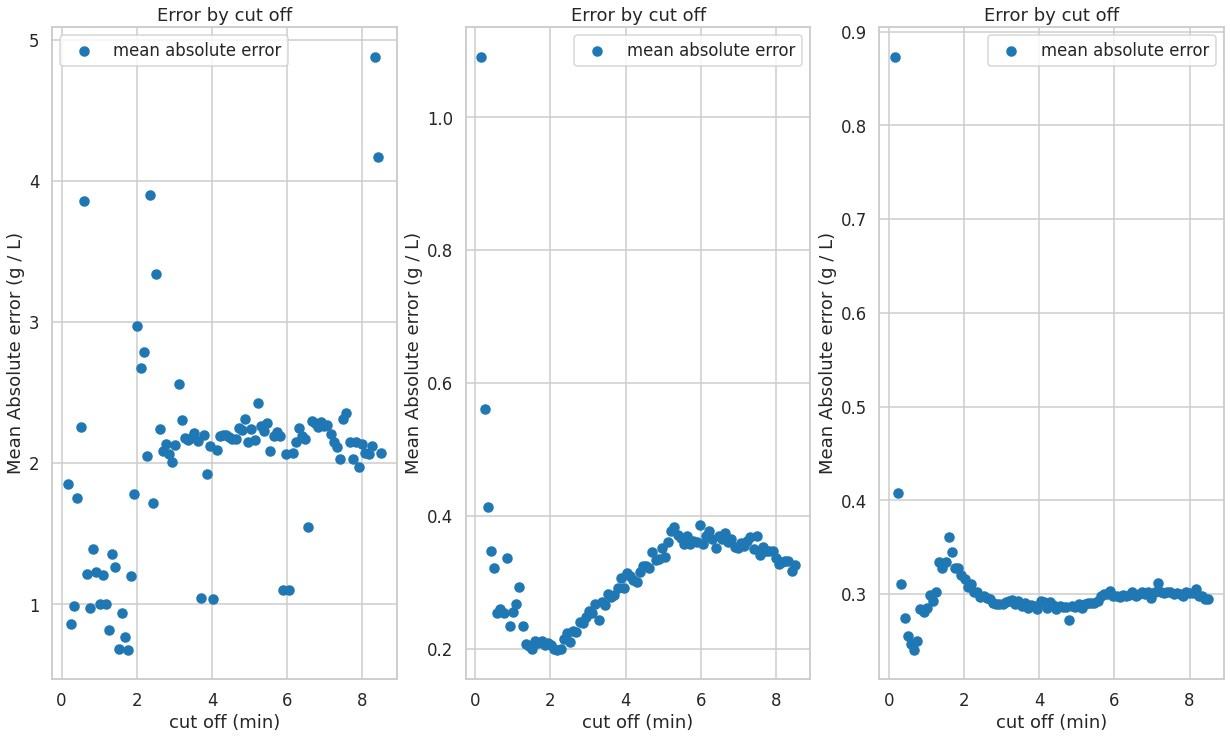

In [145]:
fig, axes = plt.subplots(1, len(errors_by_cut_off), figsize=(len(errors_by_cut_off) * 7, 12))

for ax, (key, error_data) in zip(axes.flatten(), errors_by_cut_off.items()):
    mae, rmse, _ = zip(*error_data)


    ax.scatter(
        cut_offs / 60,
        mae,
        label='mean absolute error'
    )
#     ax.scatter(
#         cut_offs / 60,
#         rmse,
#         label='root mean squared error'
#     )



    ax.set_title('Error by cut off')
    ax.set_xlabel('cut off (min)')
    ax.set_ylabel('Mean Absolute error (g / L)')
    ax.legend()



fig.savefig(
    os.path.join(
        FIG_DIR,
        'error_by_cut_off_splines_glucose_batch.png'
    ),
    transparent=True,    
)

## Simple Model vs. Semi Supervised

In [146]:
import pickle
import sklearn.metrics

with open('semi_supervised_nn.pickle', 'rb') as handle:
    semi_supervised_results = pickle.load(handle)
    
measurement_duration = max(curves['No. 3 at 37 degrees'][0].points_in_time)
cut_off_nn_minutes = sorted([one / 100 * measurement_duration for one in semi_supervised_results.keys()])

sorted_cut_off_idxes = sorted(semi_supervised_results.keys())

labels_predictions = [list(zip(*semi_supervised_results[idx])) for idx in sorted_cut_off_idxes]
mae_nn = [
    sklearn.metrics.mean_absolute_error(np.array(labels), np.array(predictions))
    for labels, predictions in labels_predictions
]
mae_nn

[0.16594569466330789,
 0.10515282289548354,
 0.151974003423344,
 0.15017779171466827,
 0.15016184679486536,
 0.15897207774899222,
 0.1682953197847713,
 0.149259476499124,
 0.13034890659830786,
 0.11564197052608836,
 0.11066843162883412,
 0.10503178970380263,
 0.07260261205109683,
 0.08686592294411226,
 0.15573588487776843,
 0.11297324950044806,
 0.1579506979747252,
 0.08187961510636589,
 0.08979445154016669]

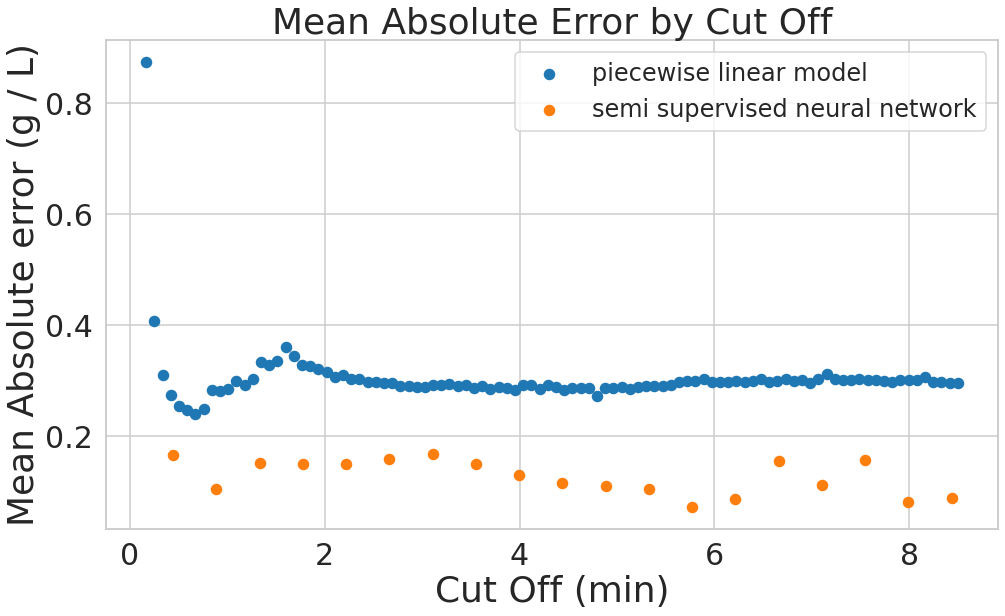

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

error_data = errors_by_cut_off['No. 3 at 37 degrees']
mae, rmse, _ = zip(*error_data)


ax.scatter(
    cut_offs / 60,
    mae,
    label='piecewise linear model'
)


ax.scatter(
    cut_off_nn_minutes,
    mae_nn,
    label='semi supervised neural network'
)



ax.set_title('Mean Absolute Error by Cut Off')
ax.set_xlabel('Cut Off (min)')
ax.set_ylabel('Mean Absolute error (g / L)')
ax.legend()



fig.savefig(
    os.path.join(
        FIG_DIR,
        'piecewise_linear_vs_nn.png'
    ),
    transparent=True,    
)

## Final Voltages Plot

Mean Absolute Error of sensor No. 1 at room temperature amounts to 2.8412
Mean Absolute Error of sensor No. 2 at 37 degrees amounts to 0.2515
Mean Absolute Error of sensor No. 3 at 37 degrees amounts to 0.2071


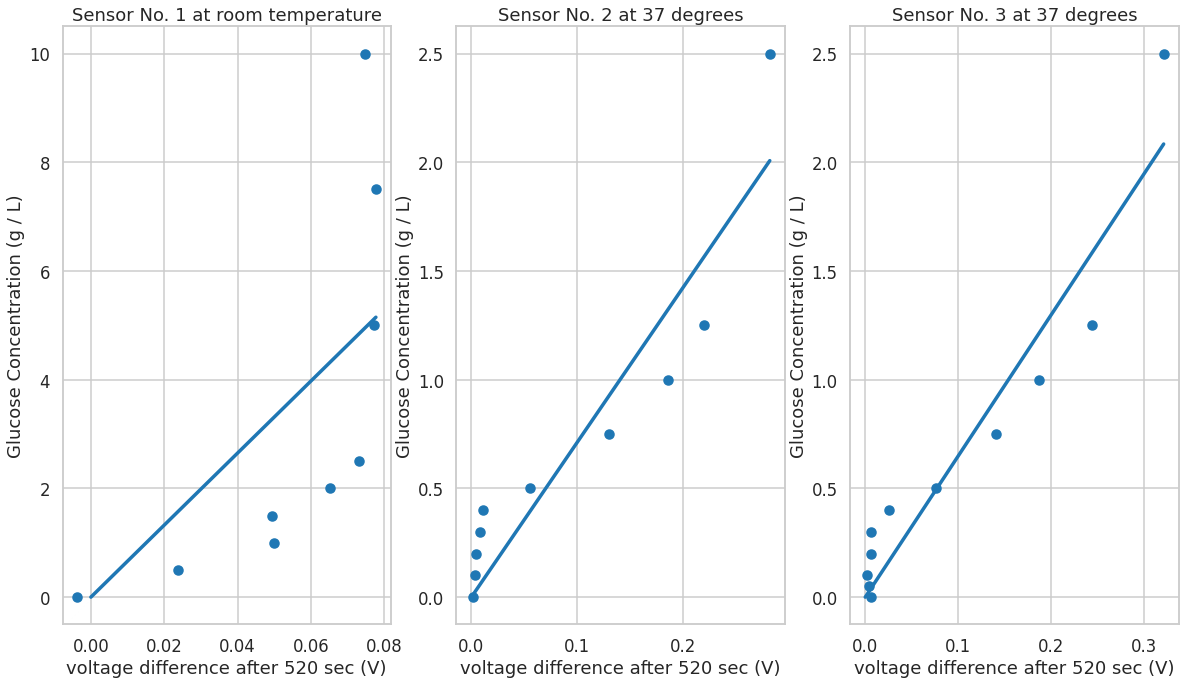

In [257]:
cut_off_sec = 520
glucose_split = 0.8
mae_results_one_split = {
    key: mae_by_cut_off(
        cut_off_sec,
        one_set,
        glucose_split=glucose_split,
    )
    for key, one_set in curves.items()
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 11))

for (
    ax,
    (
        key,
        (
            mae,
            rmse,
            model,
            voltage_differences,
            concentrations
        )
    )
) in zip(axes, mae_results_one_split.items()):
    ax.scatter(
        voltage_differences,
        concentrations,
    )
    
    print('Mean Absolute Error of sensor %s amounts to %6.4f' % (key, mae))

    ax.plot(
        np.linspace(0., np.max(voltage_differences), 100),
        model.predict(np.linspace(0., np.max(voltage_differences), 100)[:, np.newaxis])
    )

    ax.set_title('Sensor %s' % (key))
    ax.set_xlabel('voltage difference after %s sec (V)' % cut_off_sec)
    ax.set_ylabel('Glucose Concentration (g / L)')
    

fig.savefig(
    os.path.join(
        FIG_DIR,
        'calibration_final_voltage.png'
    ),
    transparent=True,    
)

